In [2]:
import random
import sklearn
import warnings
import os
import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy import stats
warnings.filterwarnings('ignore')

In [3]:
def make_submission(prediction, filename):
    assert type(prediction) == np.ndarray, "Pass a numpy.ndarray"
    assert prediction.shape[0] == 80, f"Missing data points Expected 80 Got {prediction.shape[0]}"
    assert prediction.shape[1] == 595, f"Number of features predicted is not correct Excpected 595 Got {prediction.shape[1]}"
    assert type(filename) == str, "Filename must be a string"
    assert '.csv' in filename, "Add extension '.csv'"
    
    df = pd.DataFrame(prediction.flatten())
    df.index.name = "ID"
    df = df.rename(columns={0:"predicted"})
    df.to_csv(filename)
    print(f"{filename} saved at {os.getcwd()}")
    return df

In [4]:
def remove_id_column(dataframe):
    assert type(dataframe) == pd.core.frame.DataFrame, f"{type(dataframe)} != pd.core.frame.DataFrame"
    return dataframe.drop("ID", 1)


In [5]:
def try_models(train,train_labels,test,test_labels, results):

    def test_model(model):

        model.fit(train, train_labels)
        test_predict = model.predict(test)
        actual = test_labels.flatten()
        predicted = test_predict.flatten()
        scores = mse(predicted, actual)

        return scores

    model = linear_model.LinearRegression()
    test_result = test_model(model)
    model_name = 'LinearRegression'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = linear_model.Ridge()
    test_result = test_model(model)
    model_name = 'Ridge'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(SGDRegressor())
    test_result = test_model(model)
    model_name = 'SGDRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(linear_model.BayesianRidge())
    test_result = test_model(model)
    model_name = 'BayesianRidge'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = MultiOutputRegressor(linear_model.HuberRegressor())
    test_result = test_model(model)
    model_name = 'HuberRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = linear_model.Lasso(alpha=1e-4)
    test_result = test_model(model)
    model_name = 'Lasso'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
        
    model = BaggingRegressor()
    test_result = test_model(model)
    model_name = 'BaggingRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = ElasticNet()
    test_result = test_model(model)
    model_name = 'ElasticNet'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = RandomForestRegressor()
    test_result = test_model(model)
    model_name = 'RandomForestRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(AdaBoostRegressor())
    test_result = test_model(model)
    model_name = 'AdaBoostRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = MultiOutputRegressor(svm.SVR(kernel="linear"))
    test_result = test_model(model)
    model_name = 'SVR(kernel="linear")'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
       
    model = MultiOutputRegressor(svm.SVR(kernel="rbf"))
    test_result = test_model(model)
    model_name = 'SVR(kernel="rbf")'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    return results

In [102]:
random.seed(1)
def cv(data, labels, n_fold, model=None, shuffle=False):
    kf = KFold(n_splits=n_fold, shuffle=shuffle)
    results = {}
    if model is not None:
        results['YourModel'] = []
    for train_index, test_index in kf.split(data):
        train = data[train_index, :]
        train_labels = labels[train_index, :]
        test = data[test_index, :]
        test_labels = labels[test_index, :]

        scaler = MinMaxScaler()
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)

        pca = PCA(0.70)
        pca.fit(train)
        train = pca.transform(train)
        test = pca.transform(test)

        if model == None:
            results = try_models(train,train_labels,test,test_labels, results)
        else:
            model.fit(train, train_labels)
            test_predict = model.predict(test)
            actual = test_labels.flatten()
            predicted = test_predict.flatten()
            scores = mse(predicted, actual)
            results['YourModel'].append(scores)

    results_df = pd.DataFrame(results).T
    variance = results_df.var(axis=1)
    mean = results_df.mean(axis=1)
    results_df.insert(5, "Var", variance)
    results_df.insert(6, "Mean", mean)  

    return results_df

In [34]:
def train_model_and_predict(model, data, labels, test):
    scaler = StandardScaler()
    scaler.fit(data)
    train = scaler.transform(data)

    pca = PCA(0.70)
    pca.fit(train)
    train = pca.transform(train)
    model.fit(train, labels)
    
    test_data = scaler.transform(test)
    test_data = pca.transform(test_data)
    prediction = model.predict(test_data)

    return model, prediction

In [123]:
def draw_hist(data, x_range, y_range):
    
    fig, axs = plt.subplots(x_range, y_range)
    
    for i in range(x_range):
        for j in range(y_range):
            rand_temp = np.random.randint(0, len(data))
            axs[i, j].hist(data[data.columns[rand_temp]])
            axs[i, j].set_title(rand_temp)
            
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [124]:
def draw_scatter(data, x_range, y_range):
    
    fig, axs = plt.subplots(x_range, y_range)
    
    for i in range(x_range):
        for j in range(y_range):
            rand_temp = np.random.randint(0, len(data))
            axs[i, j].scatter(range(len(data[data.columns[rand_temp]])), data[data.columns[rand_temp]], c=np.random.rand(len(data[data.columns[rand_temp]])))
            axs[i, j].set_title(rand_temp)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [125]:
def draw_corr(data):
    plt.matshow(X.corr())
    plt.show()

In [129]:
def scatter_hist_helper(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

In [130]:
def scatter_hist(data, f_1, f_2):
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005
    
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    # use the previously defined function
    scatter_hist_helper(data[data.columns[f_1]], data[data.columns[f_2]], ax, ax_histx, ax_histy)
    
    plt.show()

In [115]:
X = pd.read_csv('train_t0.csv')
Y = pd.read_csv('train_t1.csv')
test = pd.read_csv('test_t0.csv')
X = remove_id_column(X)
Y = remove_id_column(Y)
test = remove_id_column(test)

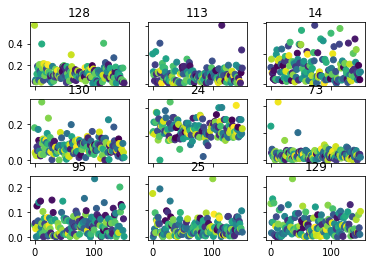

In [126]:
draw_scatter(X, 3, 3)

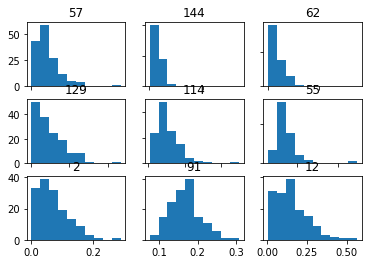

In [127]:
draw_hist(X, 3, 3)

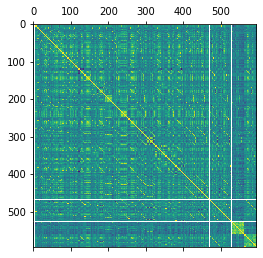

In [128]:
draw_corr(X)

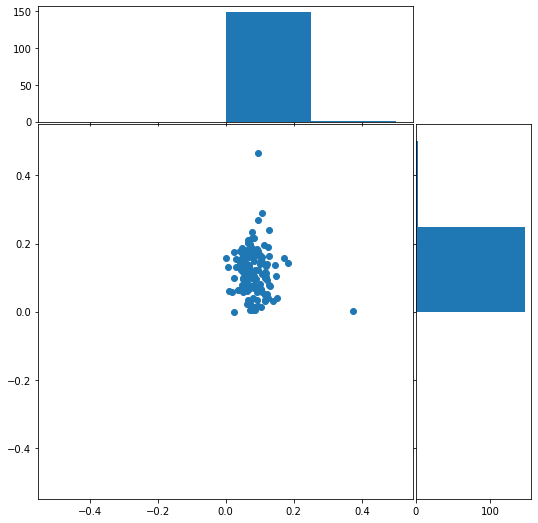

In [131]:
scatter_hist(X, 5, 7)

In [ ]:
clf = RandomForestRegressor(n_estimators=2000)
model, prediction = train_model_and_predict(clf, X.to_numpy(), Y.to_numpy(), test.to_numpy())
make_submission(prediction, "rfr2000.csv")

In [103]:
fold5_results = cv(X.to_numpy(), Y.to_numpy(), n_fold=5, model=clf)

In [109]:
fold5_resultss = fold5_results.rename(index={"YourModel": "RandomForestRegressor"}).T
fold5_resultss.head()

,RandomForestRegressor
0,0.005226
1,0.002492
2,0.003680
3,0.003792
4,0.006536


In [120]:
data = X.to_numpy()
labels = Y.to_numpy()
test_data = test.to_numpy()

square_diff = np.square(labels - data)
sum = np.sum(square_diff, axis=0)
locs = np.where(sum == 0)
data = np.delete(data, locs, 1)
test_data = np.delete(test_data, locs, 1)

clf = RandomForestRegressor(n_estimators=2000)
model, prediction = train_model_and_predict(clf, data, labels, test_data)
make_submission(prediction, "rfr2000_featuredrop.csv")

rfr2000_featuredrop.csv saved at /content


,predicted
ID,
0,0.047336
1,0.092840
2,0.109411
3,0.000000
4,0.047336
...,...
47595,0.132831
47596,0.128207
47597,0.033560


In [121]:
results = cv(data, labels, 5, clf)

In [122]:
fold5_resultss = results.rename(index={"YourModel": "Random Forest With Feature Drop"}).T
fold5_resultss.head()

,Random Forest With Feature Drop
0,0.005160
1,0.002487
2,0.003809
3,0.003776
4,0.006614


In [69]:
data = X.to_numpy()
labels = Y.to_numpy()

diff = labels - data
diff_norm = sklearn.preprocessing.normalize(diff, axis=0)

Cleaning with z score

In [47]:
z = np.abs(stats.zscore(diff, 1))
thresh = 4
data_clean = data[(z<thresh).all(axis=1)]
data_clean.shape
labels_clean = labels[(z<thresh).all(axis=1)]
labels_clean.shape
z_results = cv(data_clean, labels_clean, 5, shuffle=True)
z_results.head(20)

,0,1,2,3,4,Var,Mean
LinearRegression,0.002126,0.003580,0.002185,0.002352,0.004972,1.516744e-06,0.003043
Ridge,0.002117,0.003546,0.002167,0.002343,0.004960,1.510738e-06,0.003027
SGDRegressor,0.002263,0.003578,0.002333,0.002614,0.005447,1.788438e-06,0.003247
BayesianRidge,0.001982,0.002810,0.001925,0.002238,0.004820,1.455343e-06,0.002755
HuberRegressor,0.001976,0.003178,0.002056,0.002281,0.005009,1.619006e-06,0.002900
Lasso,0.002120,0.003564,0.002174,0.002346,0.004966,1.515140e-06,0.003034
BaggingRegressor,0.002005,0.002632,0.003134,0.002408,0.005054,1.425144e-06,0.003047
ElasticNet,0.002386,0.002542,0.002291,0.002559,0.005241,1.577029e-06,0.003004
RandomForestRegressor,0.001956,0.002605,0.002465,0.002143,0.004853,1.377453e-06,0.002805
AdaBoostRegressor,0.002075,0.002420,0.002376,0.002261,0.005051,1.549445e-06,0.002837


In [51]:
z = np.abs(stats.zscore(diff, 1))
thresh = 4
data_clean = data[(z<thresh).all(axis=1)]
data_clean.shape
labels_clean = labels[(z<thresh).all(axis=1)]
labels_clean.shape

model = RandomForestRegressor(n_estimators=200)
model, prediction = train_model_and_predict(model, data_clean, labels_clean, test.to_numpy()) 

In [52]:
prediction = make_submission(prediction, 'RandomForestZClean.csv')

RandomForestZClean.csv saved at /content


In [37]:
clf = IsolationForest(random_state=0).fit(diff)
k1 = clf.predict(diff)
data_clean = data[np.where(k1==1)]
clf2 = IsolationForest(random_state=0).fit(data)
k2 = clf2.predict(data)
clf3 = IsolationForest(random_state=0).fit(labels)
k3 = clf3.predict(labels)
anomalies = np.logical_and(k3==1, np.logical_and(k2==1, k1==1))
locations = np.where(anomalies)

In [17]:
data_clean = data[locations]
labels_clean = labels[locations]
print(data_clean.shape)
print(labels_clean.shape)

(139, 595)
(139, 595)


In [18]:
results = cv(data_clean, labels_clean, 5, shuffle=True)

In [19]:
results.head(20)

,0,1,2,3,4,Var,Mean
LinearRegression,0.002202,0.002625,0.002400,0.001872,0.002648,1.044914e-07,0.002349
Ridge,0.002195,0.002615,0.002392,0.001867,0.002639,1.032097e-07,0.002342
SGDRegressor,0.002276,0.002714,0.002389,0.001849,0.002671,1.221819e-07,0.002380
BayesianRidge,0.002089,0.002470,0.002244,0.001818,0.002477,7.693344e-08,0.002220
HuberRegressor,0.002209,0.002638,0.002361,0.001857,0.002634,1.066506e-07,0.002340
Lasso,0.002193,0.002615,0.002392,0.001866,0.002639,1.035323e-07,0.002341
BaggingRegressor,0.002284,0.002730,0.002468,0.001983,0.002795,1.107201e-07,0.002452
ElasticNet,0.002472,0.002819,0.002506,0.002242,0.002828,6.251944e-08,0.002574
RandomForestRegressor,0.002135,0.002528,0.002297,0.001861,0.002515,7.820858e-08,0.002267
AdaBoostRegressor,0.002198,0.002667,0.002378,0.002016,0.002615,7.582812e-08,0.002375


In [39]:
data_clean = data[locations]
labels_clean = labels[locations]

model = RandomForestRegressor(n_estimators=200)
model, prediction = train_model_and_predict(model, data_clean, labels_clean, test.to_numpy()) 

In [40]:
prediction = make_submission(prediction, "RandomForestWIsolationForest.csv")

RandomForestWIsolationForest.csv saved at /content


In [95]:
train = X.to_numpy()
train_labels = Y.to_numpy()

scaler = StandardScaler()

scaler.fit(train)
train = scaler.transform(train)
test_data = scaler.transform(test)

pca = PCA(0.70)
pca.fit(train)
train = pca.transform(train)
test_data = pca.transform(test_data)

clf = RandomForestRegressor(n_estimators=2000)
clf.fit(train, train_labels)
prediction = clf.predict(test_data)
make_submission(prediction, "mse214_a.csv")

mse214_a.csv saved at /content


,predicted
ID,
0,0.046124
1,0.087537
2,0.104052
3,0.000000
4,0.046124
...,...
47595,0.128067
47596,0.122066
47597,0.036526
